In [1]:
import scvi
import torch
import os
import re
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt

/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_categorical_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/docrep/decorators.py:43: SyntaxWarning: 'param_continuous_covariate_keys' is not a valid key!
  doc = func(self, args[0].__doc__, *args[1:], **kwargs)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analysis/lib/python3.11/site-packages/anndata/utils.py:434: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/minhang/miniconda3/envs/mds_responder_analy

In [5]:
parquet_file_path = '/home/minhang/mds_project/data/cohort_adata/multiVI_model/batch_corrected_normalized_expression.parquet.gz'
try:
    norm_exp_df = pd.read_parquet(parquet_file_path, engine='pyarrow')
    print("Successfully read Parquet file.")
    print("Shape of norm_exp_df:", norm_exp_df.shape)
    print(norm_exp_df.head())
except Exception as e:
    print(f"Error reading Parquet file: {e}")
    print("Ensure 'pyarrow' or 'fastparquet' is installed in your environment (pip install pyarrow).")

Successfully read Parquet file.
Shape of norm_exp_df: (192149, 36601)
                            A1BG  A1BG-AS1      A1CF       A2M   A2M-AS1  \
barcode                                                                    
E03_AAACAGCCAAACGCGA-1  0.000013  0.000003  0.000002  0.000010  0.000004   
E03_AAACAGCCAAATTCGT-2  0.000017  0.000003  0.000004  0.000033  0.000008   
E03_AAACAGCCAATCCTAG-2  0.000013  0.000002  0.000005  0.000025  0.000007   
E03_AAACAGCCAATGCCCG-1  0.000016  0.000005  0.000003  0.000017  0.000005   
E03_AAACAGCCACAATGCC-2  0.000007  0.000003  0.000005  0.000022  0.000009   

                           A2ML1  A2ML1-AS1  A2ML1-AS2       A3GALT2  \
barcode                                                                
E03_AAACAGCCAAACGCGA-1  0.000013   0.000005   0.000063  1.152072e-06   
E03_AAACAGCCAAATTCGT-2  0.000008   0.000007   0.000042  6.032975e-07   
E03_AAACAGCCAATCCTAG-2  0.000007   0.000004   0.000052  5.727828e-07   
E03_AAACAGCCAATGCCCG-1  0.000026   0.

In [2]:
# --- Define Paths ---
adata_path = '/home/minhang/mds_project/data/cohort_adata/multiVI_model/adata.h5ad'
# Path for the new AnnData object we will create
output_adata_corrected_rna_path = '/home/minhang/mds_project/data/cohort_adata/multiVI_model/adata_multivi_corrected_rna.h5ad'

# --- Load original AnnData ---
print(f"Loading original AnnData from: {adata_path}")
adata_mvi = sc.read_h5ad(adata_path)
print(f"Original AnnData shape: {adata_mvi.shape}")
adata_mvi.var_names_make_unique() # Ensure unique var names

# Ensure norm_exp_df is loaded from the previous step (reading Parquet/CSV)
if 'norm_exp_df' not in locals():
    print("ERROR: norm_exp_df is not loaded. Please load it from your saved file first.")
else:
    print(f"Normalized RNA DataFrame shape: {norm_exp_df.shape}")

Loading original AnnData from: /home/minhang/mds_project/data/cohort_adata/multiVI_model/adata.h5ad
Original AnnData shape: (192149, 335386)
ERROR: norm_exp_df is not loaded. Please load it from your saved file first.


In [4]:
adata_mvi.obs

orig.ident  nCount_RNA  nFeature_RNA library  \
barcode                                                                   
E03_AAACAGCCAAACGCGA-1  SeuratProject        4568          2135       A   
E03_AAACAGCCAAATTCGT-2  SeuratProject        1376           751       B   
E03_AAACAGCCAATCCTAG-2  SeuratProject        5154          2285       B   
E03_AAACAGCCAATGCCCG-1  SeuratProject        4397          2090       A   
E03_AAACAGCCACAATGCC-2  SeuratProject        2469          1354       B   
...                               ...         ...           ...     ...   
E20_TTTGTTGAGGTGCGAT-2  SeuratProject        9792          3872     POS   
E20_TTTGTTGAGTTGGACG-2  SeuratProject        8840          3261     POS   
E20_TTTGTTGGTTTCTTAC-2  SeuratProject        6618          2976     POS   
E20_TTTGTTGTCACCTCTG-2  SeuratProject       10468          3738     POS   
E20_TTTGTTGTCTCGGTAA-2  SeuratProject        9049          3544     POS   

                       exp.ID  percent.mt  nCount_ATAC  nFeature_ATAC  \
barcode                                                                 
E03_AAACAGCCAAACGCGA-1    E03    6.195271       2858.0         2718.0   
E03_AAACAGCCAAATTCGT-2    E03   23.982558       4113.0         3558.0   
E03_AAACAGCCAATCCTAG-2    E03    6.519208       1696.0         1641.0   
E03_AAACAGCCAATGCCCG-1    E03    6.731863       2047.0         1948.0   
E03_AAACAGCCACAATGCC-2    E03   15.998380       9167.0         7898.0   
...                       ...         ...          ...            ...   
E20_TTTGTTGAGGTGCGAT-2    E20    5.361520          NaN            NaN   
E20_TTTGTTGAGTTGGACG-2    E20    3.914027          NaN            NaN   
E20_TTTGTTGGTTTCTTAC-2    E20    4.865518          NaN            NaN   
E20_TTTGTTGTCACCTCTG-2    E20    2.808559          NaN            NaN   
E20_TTTGTTGTCTCGGTAA-2    E20    4.409327          NaN            NaN   

                         nCount_dsb  nFeature_dsb  ...   marker       Time  \
barcode                                            ...                       
E03_AAACAGCCAAACGCGA-1    51.630415            89  ...  CD34pos     preSCT   
E03_AAACAGCCAAATTCGT-2   291.320909           129  ...  CD34pos    Relapse   
E03_AAACAGCCAATCCTAG-2   572.210360           141  ...  CD34pos    Relapse   
E03_AAACAGCCAATGCCCG-1   151.173974           106  ...  CD34pos     preSCT   
E03_AAACAGCCACAATGCC-2   388.613006           144  ...  CD34pos    Relapse   
...                             ...           ...  ...      ...        ...   
E20_TTTGTTGAGGTGCGAT-2  1072.256399            90  ...  CD34pos  Relapse_1   
E20_TTTGTTGAGTTGGACG-2   882.894488           100  ...  CD34pos  Relapse_2   
E20_TTTGTTGGTTTCTTAC-2   737.563530            83  ...  CD34pos  Relapse_1   
E20_TTTGTTGTCACCTCTG-2   598.173333            76  ...  CD34pos  Relapse_2   
E20_TTTGTTGTCTCGGTAA-2   644.122055            77  ...  CD34pos  Relapse_2   

                       batch   Tech         sample     source  \
barcode                                                         
E03_AAACAGCCAAACGCGA-1  E03A  Multi     P01_preSCT  recipient   
E03_AAACAGCCAAATTCGT-2  E03B  Multi    P01_Relapse  recipient   
E03_AAACAGCCAATCCTAG-2  E03B  Multi    P01_Relapse  recipient   
E03_AAACAGCCAATGCCCG-1  E03A  Multi     P01_preSCT  recipient   
E03_AAACAGCCACAATGCC-2  E03B  Multi    P01_Relapse  recipient   
...                      ...    ...            ...        ...   
E20_TTTGTTGAGGTGCGAT-2  E20P   CITE  P13_Relapse_1  recipient   
E20_TTTGTTGAGTTGGACG-2  E20P   CITE  P13_Relapse_2  recipient   
E20_TTTGTTGGTTTCTTAC-2  E20P   CITE  P13_Relapse_1  recipient   
E20_TTTGTTGTCACCTCTG-2  E20P   CITE  P13_Relapse_2  recipient   
E20_TTTGTTGTCTCGGTAA-2  E20P   CITE  P13_Relapse_2  recipient   

                        soup.singlet_posterior _indices _scvi_batch  \
barcode                                                               
E03_AAACAGCCAAACGCGA-1                     1.0        0           1   
E03_AAACAGCCAAATTCGT-2     

In [7]:
# In a Jupyter Notebook cell
print("\nValidating cell order and count...")
validation_passed = True

if adata_mvi.n_obs != norm_exp_df.shape[0]:
    print(f"ERROR: Cell count mismatch! Original: {adata_mvi.n_obs}, Normalized: {norm_exp_df.shape[0]}")
    validation_passed = False
else:
    if not all(adata_mvi.obs_names == norm_exp_df.index):
        print("WARNING: Cell order mismatch or different cell names!")
        if set(adata_mvi.obs_names) == set(norm_exp_df.index):
            print("Attempting to reorder normalized DataFrame to match original AnnData...")
            try:
                norm_exp_df = norm_exp_df.loc[adata_mvi.obs_names]
                if all(adata_mvi.obs_names == norm_exp_df.index):
                    print("Cell order successfully matched by reindexing.")
                else:
                    print("ERROR: Reordering failed. Cell names still do not match precisely after reindex attempt.")
                    validation_passed = False
            except Exception as e:
                print(f"ERROR during reordering: {e}")
                validation_passed = False
        else:
            print("Cell sets (names) are different. Cannot make them match by reordering.")
            validation_passed = False
    else:
        print("Cell order and count are correct.")

if not validation_passed:
    print("Cell validation failed. Please check your data before proceeding.")


Validating cell order and count...
Cell order and count are correct.


In [10]:
# In a Jupyter Notebook cell
if validation_passed: # Proceed only if cell validation passed
    print("\nValidating gene order and count...")
    gene_expression_mask = (adata_mvi.var["modality"] == "Gene Expression")
    original_gene_names = adata_mvi.var_names[gene_expression_mask].tolist()

    if len(original_gene_names) != norm_exp_df.shape[1]:
        print(f"ERROR: Gene count mismatch! Original AnnData genes: {len(original_gene_names)}, Normalized DataFrame columns: {norm_exp_df.shape[1]}")
        validation_passed = False
    else:
        if not all(original_gene_names == norm_exp_df.columns):
            print("WARNING: Gene order mismatch or different gene names in columns.")
            if set(original_gene_names) == set(norm_exp_df.columns):
                print("Attempting to reorder normalized DataFrame columns to match original AnnData gene order...")
                try:
                    norm_exp_df = norm_exp_df[original_gene_names] # Reorder columns
                    if all(original_gene_names == norm_exp_df.columns):
                        print("Gene order successfully matched by reindexing columns.")
                    else:
                        print("ERROR: Reordering columns failed. Gene names still do not match order after reindex attempt.")
                        validation_passed = False
                except Exception as e:
                    print(f"ERROR during column reordering: {e}")
                    validation_passed = False
            else:
                print("Gene sets (names) are different. Cannot make them match by reordering columns.")
                validation_passed = False
        else:
            print("Gene order and count are correct.")

if not validation_passed:
    print("Gene validation failed. Please check your data before proceeding.")


Validating gene order and count...
Gene order and count are correct.


In [15]:
adata_mvi

AnnData object with n_obs × n_vars = 192149 × 335386
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'ID', 'modality', 'chr', 'start', 'end'
    uns: '_scvi_manager_uuid', '_scvi_uuid'
    obsm: 'ADT', '_scvi_extra_categorical_covs'

Takes 22 mins to save the adata

In [17]:
# In a Jupyter Notebook cell
if validation_passed: # Proceed only if all validations passed
    print("\nCreating new AnnData object for corrected RNA data...")

    # Get the var DataFrame corresponding to the genes in norm_exp_df
    # We've already ensured norm_exp_df.columns matches original_gene_names if validation passed
    rna_var_df = adata_mvi.var.loc[original_gene_names].copy() # Use the validated gene names

    corrected_rna_adata = anndata.AnnData(
        X=norm_exp_df.values,
        obs=adata_mvi.obs.copy(), # Use original cell metadata
        var=rna_var_df            # Use var metadata for the selected genes
    )
    # If you have the latent space (X_multivi) corresponding to adata_mvi,
    # you could add it here if desired, ensuring cell order matches.
    # if 'X_multivi' in adata_mvi.obsm:
    #    corrected_rna_adata.obsm['X_multivi'] = adata_mvi.obsm['X_multivi'].copy()

    print(f"Created new AnnData object for corrected RNA data with shape: {corrected_rna_adata.shape}")
    print(f"Saving new AnnData object to: {output_adata_corrected_rna_path}")
    try:
        corrected_rna_adata.write_h5ad(output_adata_corrected_rna_path, compression="gzip")
        print("Corrected RNA AnnData saved successfully with gzip compression.")
    except Exception as e:
        print(f"Error saving AnnData: {e}")
else:
    print("\nSkipping AnnData creation and saving due to previous validation errors.")


Creating new AnnData object for corrected RNA data...
Created new AnnData object for corrected RNA data with shape: (192149, 36601)
Saving new AnnData object to: /home/minhang/mds_project/data/cohort_adata/multiVI_model/adata_multivi_corrected_rna.h5ad
Corrected RNA AnnData saved successfully with gzip compression.


Load in batch corrected adata with latent rep

In [6]:
output_adata_corrected_rna_path = '/home/minhang/mds_project/data/cohort_adata/multiVI_model/adata_multivi_corrected_rna.h5ad'

batch_corrected_rna_adata = sc.read_h5ad(output_adata_corrected_rna_path) # takes 2 mins

In [11]:
sparsified_corrected_rna_adata = sc.read_h5ad('/home/minhang/mds_project/data/cohort_adata/multiVI_model/adata_multivi_corrected_rna_final_sparseRNA.h5ad')

In [14]:
print(type(sparsified_corrected_rna_adata.X))
sparsified_corrected_rna_adata

<class 'scipy.sparse._csr.csr_matrix'>


AnnData object with n_obs × n_vars = 192149 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'CN.label', 'predicted.annotation.score', 'predicted.annotation', 'predicted.pseudotime.score', 'predicted.pseudotime', 'timepoint_type'
    var: 'ID', 'modality', 'chr', 'start', 'end'
    uns: 'CN.label_colors', 'Tech_colors', 'neighbors', 'patient_colors', 'predicted.annotation_colors', 'sample_colors', 'timepoint_type_colors', 'umap'
    obsm: 'X_multivi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [2]:
adata_path = '/home/minhang/mds_project/data/cohort_adata/multiVI_model/adata.h5ad'
original_adata = sc.read_h5ad(adata_path) # takes 2 mins

In [4]:
print(f'Batch corrected adata data matrix type: {type(batch_corrected_rna_adata.X)}, \n original adata data matrix type: {type(original_adata.X)}')

Batch corrected adata data matrix type: <class 'numpy.ndarray'>, 
 original adata data matrix type: <class 'scipy.sparse._csr.csr_matrix'>


In [10]:
list(batch_corrected_rna_adata.obs['predicted.annotation'].unique())

['MEP-MkP',
 'HSC/MPP1',
 'HSC/MPP2',
 'MEP-EP',
 'LMPP',
 'EBM',
 'cDC',
 'NP1',
 'NP2',
 'CLP',
 'pDC2',
 'pDC1',
 'ncMono']

Inspecting ATAC-seq Data Coverage

In [14]:
if 'Tech' in original_adata.obs.columns and 'modality' in original_adata.var.columns:
    print("\n--- Inspecting ATAC-seq Data Coverage ---")

    # Identify peak regions (features)
    peak_mask = original_adata.var['modality'] == 'peaks'
    peak_indices = np.where(peak_mask)[0] # Get integer indices of peak columns
    n_peaks = len(peak_indices)
    print(f"Number of peak features identified: {n_peaks}")

    if n_peaks > 0:
        # Extract the ATAC portion of the data matrix
        # original_adata.X is likely sparse, so sum over columns (axis=1) for each cell
        atac_counts_per_cell = original_adata.X[:, peak_indices].sum(axis=1)
        # If X is sparse, the sum might be a matrix, convert to 1D array
        if not isinstance(atac_counts_per_cell, np.ndarray):
            atac_counts_per_cell = np.asarray(atac_counts_per_cell).ravel()
        
        original_adata.obs['total_atac_counts'] = atac_counts_per_cell
        
        print("\nSummary of total ATAC counts per cell by 'Tech':")
        print(original_adata.obs.groupby('Tech')['total_atac_counts'].describe())

        # Count cells with any ATAC signal by 'Tech'
        cells_with_atac_signal = original_adata.obs['total_atac_counts'] > 0
        print("\nNumber of cells with >0 total ATAC counts by 'Tech':")
        print(original_adata.obs[cells_with_atac_signal].groupby('Tech').size())
        
        print("\nNumber of cells with 0 total ATAC counts by 'Tech':")
        print(original_adata.obs[~cells_with_atac_signal].groupby('Tech').size())

        # Which samples have cells with ATAC signal?
        if 'sample' in original_adata.obs.columns:
            print("\nSamples with ATAC-positive cells (showing count of such cells per sample):")
            samples_with_atac = original_adata.obs[cells_with_atac_signal].groupby('sample').size()
            print(samples_with_atac[samples_with_atac > 0])
    else:
        print("No peak features found in original_adata.var['modality'].")
else:
    print("Skipping ATAC inspection: 'Tech' or 'modality' column missing.")


--- Inspecting ATAC-seq Data Coverage ---
Number of peak features identified: 298785



Summary of total ATAC counts per cell by 'Tech':
          count        mean          std    min     25%     50%     75%  \
Tech                                                                      
CITE    65829.0     0.00000     0.000000    0.0     0.0     0.0     0.0   
Multi  126320.0  6441.31292  5435.072109  202.0  2631.0  5394.0  8751.0   

           max  
Tech            
CITE       0.0  
Multi  94856.0  

Number of cells with >0 total ATAC counts by 'Tech':
Tech
CITE          0
Multi    126320
dtype: int64

Number of cells with 0 total ATAC counts by 'Tech':
Tech
CITE     65829
Multi        0
dtype: int64

Samples with ATAC-positive cells (showing count of such cells per sample):
sample
P01_MRD_1            589
P01_MRD_2           6708
P01_Relapse         3752
P01_Relapse_2       1363
P01_preSCT         14830
P01_preSCT_2        6877
P02_MRD_1            880
P02_Relapse_1        255
P02_Relapse_2        505
P02_Relapse_3       3559
P02_Relapse_4       7070
P02_preSCT_1      

/tmp/ipykernel_443330/900313426.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(original_adata.obs.groupby('Tech')['total_atac_counts'].describe())
/tmp/ipykernel_443330/900313426.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(original_adata.obs[cells_with_atac_signal].groupby('Tech').size())
/tmp/ipykernel_443330/900313426.py:29: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(original_adata.o

Inspecting Protein (ADT) Data Coverage

In [21]:
# In a Jupyter Notebook cell (for Protein Data Coverage Inspection)

# Assuming original_adata is loaded and has 'Tech' and 'ADT' in obsm

if 'Tech' in original_adata.obs.columns and 'ADT' in original_adata.obsm:
    print("\n--- Inspecting Protein (ADT) Data Coverage (with observed=True for groupby) ---")
    
    adt_matrix = original_adata.obsm['ADT']
    if isinstance(adt_matrix, pd.DataFrame):
        adt_matrix_np = adt_matrix.values
    else:
        adt_matrix_np = adt_matrix

    if np.issubdtype(adt_matrix_np.dtype, np.number):
        total_adt_counts_per_cell = np.nansum(adt_matrix_np, axis=1)
    else:
        print("Warning: ADT matrix is not numeric. Cannot calculate sums.")
        total_adt_counts_per_cell = np.zeros(original_adata.n_obs)

    original_adata.obs['total_adt_counts'] = total_adt_counts_per_cell
    
    print("\nSummary of total ADT counts per cell by 'Tech':")
    # Add observed=True here
    print(original_adata.obs.groupby('Tech', observed=True)['total_adt_counts'].describe())

    cells_with_adt_signal = original_adata.obs['total_adt_counts'] > 0.1 
    print("\nNumber of cells with >0.1 total ADT counts by 'Tech':")
    # Add observed=True here
    print(original_adata.obs[cells_with_adt_signal].groupby('Tech', observed=True).size())
    
    print("\nNumber of cells with <=0.1 total ADT counts by 'Tech':")
    # Add observed=True here
    print(original_adata.obs[~cells_with_adt_signal].groupby('Tech', observed=True).size())

    if 'sample' in original_adata.obs.columns:
        print("\nSamples with ADT-positive cells (showing count of such cells per sample):")
        # Add observed=True here
        samples_with_adt = original_adata.obs[cells_with_adt_signal].groupby('sample', observed=True).size()
        print(samples_with_adt[samples_with_adt > 0])
else:
    print("Skipping Protein inspection: 'Tech' column or 'ADT' in obsm missing.")


--- Inspecting Protein (ADT) Data Coverage (with observed=True for groupby) ---

Summary of total ADT counts per cell by 'Tech':
          count         mean          std    min     25%     50%     75%  \
Tech                                                                       
CITE    65829.0  4651.441340  3534.793340  494.0  2254.0  3570.0  5931.0   
Multi  126320.0  1224.397918  1284.535731   58.0   621.0  1016.0  1419.0   

           max  
Tech            
CITE   33553.0  
Multi  17796.0  

Number of cells with >0.1 total ADT counts by 'Tech':
Tech
CITE      65829
Multi    126320
dtype: int64

Number of cells with <=0.1 total ADT counts by 'Tech':
Series([], dtype: int64)

Samples with ADT-positive cells (showing count of such cells per sample):
sample
P01_MRD_1            589
P01_MRD_2          18587
P01_Relapse         3752
P01_Relapse_2       1363
P01_preSCT         14830
P01_preSCT_2        6877
P02_MRD_1            880
P02_MRD_2           1479
P02_Relapse_1        255
P02_

In [13]:
# in the original adata, check how many cells have modality == 'peaks' and what samples are they in adata.obs['sample']
peaks_mask = original_adata.var["modality"] == "peaks"
peaks_genes = original_adata.var_names[peaks_mask].tolist()
print(peaks_genes[:10])

['GL000009.2:110954-111944', 'GL000009.2:113880-114773', 'GL000009.2:200708-201663', 'GL000009.2:87577-88470', 'GL000194.1:100946-101954', 'GL000194.1:104324-105184', 'GL000194.1:109528-110329', 'GL000194.1:110694-111615', 'GL000194.1:114495-115394', 'GL000194.1:121540-122364']


In [10]:
# print CN.label counts and the amount of NaN values
batch_corrected_rna_adata.obs['CN.label'].value_counts(), batch_corrected_rna_adata.obs['CN.label'].isna().sum()

(CN.label
 cancer    84193
 normal    82974
 Name: count, dtype: int64,
 24982)

In [ ]:
batch_corrected_rna_adata.obs[batch_corrected_rna_adata.obs['timepoint_type'] == 'MRD']

orig.ident  nCount_RNA  nFeature_RNA library  \
barcode                                                                   
E04_AAACAGCCAAATACCT-1  SeuratProject        3915          2102      P1   
E04_AAACAGCCAACTAGCC-1  SeuratProject        1431           998      P1   
E04_AAACAGCCAAGTGTTT-1  SeuratProject        3082          1873      P1   
E04_AAACAGCCACGAATCC-2  SeuratProject        2509          1539      P2   
E04_AAACAGCCAGGAACCA-1  SeuratProject        4255          2215      P1   
...                               ...         ...           ...     ...   
E19_TTTGTTGGTGGTAATA-4  SeuratProject        2808          1615      P2   
E19_TTTGTTGTCACACCGG-4  SeuratProject       16383          5074      P2   
E19_TTTGTTGTCCGACGGT-4  SeuratProject        2269          1508      P2   
E19_TTTGTTGTCGGAACTT-4  SeuratProject       11322          3905      P2   
E19_TTTGTTGTCTACCACC-4  SeuratProject        9576          3560      P2   

                       exp.ID  percent.mt  nCount_ATAC  nFeature_ATAC  \
barcode                                                                 
E04_AAACAGCCAAATACCT-1    E04    4.674330       7456.0         6610.0   
E04_AAACAGCCAACTAGCC-1    E04    3.983229       9306.0         8190.0   
E04_AAACAGCCAAGTGTTT-1    E04    4.899416       7531.0         6289.0   
E04_AAACAGCCACGAATCC-2    E04    3.467517       3287.0         3045.0   
E04_AAACAGCCAGGAACCA-1    E04    7.379553      12704.0        10951.0   
...                       ...         ...          ...            ...   
E19_TTTGTTGGTGGTAATA-4    E19    6.730769          NaN            NaN   
E19_TTTGTTGTCACACCGG-4    E19    1.776231          NaN            NaN   
E19_TTTGTTGTCCGACGGT-4    E19    3.305421          NaN            NaN   
E19_TTTGTTGTCGGAACTT-4    E19    1.112878          NaN            NaN   
E19_TTTGTTGTCTACCACC-4    E19    4.250209          NaN            NaN   

                        nCount_dsb  nFeature_dsb  ...  soup.singlet_posterior  \
barcode                                           ...                           
E04_AAACAGCCAAATACCT-1  177.333921           102  ...                     1.0   
E04_AAACAGCCAACTAGCC-1  178.611315           108  ...                     1.0   
E04_AAACAGCCAAGTGTTT-1  137.803213           119  ...                     1.0   
E04_AAACAGCCACGAATCC-2  157.172402           100  ...                     1.0   
E04_AAACAGCCAGGAACCA-1  224.268390           120  ...                     1.0   
...                            ...           ...  ...                     ...   
E19_TTTGTTGGTGGTAATA-4  495.175356           113  ...                     1.0   
E19_TTTGTTGTCACACCGG-4  468.243417            98  ...                     1.0   
E19_TTTGTTGTCCGACGGT-4  898.729729           125  ...                     1.0   
E19_TTTGTTGTCGGAACTT-4  500.990307           104  ...                     1.0   
E19_TTTGTTGTCTACCACC-4  690.867120           111  ...                     1.0   

                        _indices _scvi_batch  _scvi_labels  CN.label  \
barcode                                                                
E04_AAACAGCCAAATACCT-1     18582           1             0    normal   
E04_AAACAGCCAACTAGCC-1     18583           1             0    normal   
E04_AAACAGCCAAGTGTTT-1     18584           1             0    normal   
E04_AAACAGCCACGAATCC-2     18586           1             0    normal   
E04_AAACAGCCAGGAACCA-1     18590           1             0    normal   
...                          ...         ...           ...       ...   
E19_TTTGTTGGTGGTAATA-4    186990           0             0    normal   
E19_TTTGTTGTCACACCGG-4    186991           0             0    normal   
E19_TTTGTTGTCCGACGGT-4    186992           0             0    normal   
E19_TTTGTTGTCGGAACTT-4    186993           0             0    normal   
E19_TTTGTTGTCTACCACC-4    186994           0             0    normal   

                        predicted.annotation.score  predicted.annotation  \
barcode                           

In [16]:
batch_corrected_rna_adata.obsm['X_multivi'].shape

(192149, 23)

Assessing Sparsity of Corrected RNA Data

In [5]:
# In a Jupyter Notebook cell
if 'batch_corrected_rna_adata' in locals():
    print("\n--- Assessing Sparsity of Corrected RNA Data (corrected_rna_adata.X) ---")
    data_matrix = batch_corrected_rna_adata.X
    
    # Percentage of actual zeros
    actual_zeros = np.sum(data_matrix == 0)
    total_elements = data_matrix.size
    percent_actual_zeros = (actual_zeros / total_elements) * 100
    print(f"Percentage of actual zero values: {percent_actual_zeros:.2f}%")

    # Percentage of "small" values (e.g., less than 1e-5)
    small_value_threshold = 1e-5
    small_value_threshold_1 = 1e-6
    small_value_threshold_2 = 1e-7
    near_zeros = np.sum(np.abs(data_matrix) < small_value_threshold)
    near_zeros_1 = np.sum(np.abs(data_matrix) < small_value_threshold_1)
    near_zeros_2 = np.sum(np.abs(data_matrix) < small_value_threshold_2)
    percent_near_zeros = (near_zeros / total_elements) * 100
    percent_near_zeros_1 = (near_zeros_1 / total_elements) * 100
    percent_near_zeros_2 = (near_zeros_2 / total_elements) * 100
    print(f"Percentage of values smaller than {small_value_threshold}: {percent_near_zeros:.2f}%")
    print(f"Percentage of values smaller than {small_value_threshold_1}: {percent_near_zeros_1:.2f}%")
    print(f'Percentage of values smaller than {small_value_threshold_2}: {percent_near_zeros_2:.2f}%')

    # Distribution of values
    print("\nQuick look at value distribution (min, max, mean, median):")
    print(f"Min value: {np.min(data_matrix)}")
    print(f"Max value: {np.max(data_matrix)}")
    print(f"Mean value: {np.mean(data_matrix)}")
    print(f"Median value: {np.median(data_matrix)}")


--- Assessing Sparsity of Corrected RNA Data (corrected_rna_adata.X) ---
Percentage of actual zero values: 0.00%
Percentage of values smaller than 1e-05: 56.22%
Percentage of values smaller than 1e-06: 13.05%
Percentage of values smaller than 1e-07: 0.46%

Quick look at value distribution (min, max, mean, median):
Min value: 2.133910834018209e-15
Max value: 0.41019248962402344
Mean value: 2.732134635152761e-05
Median value: 7.128868674044497e-06


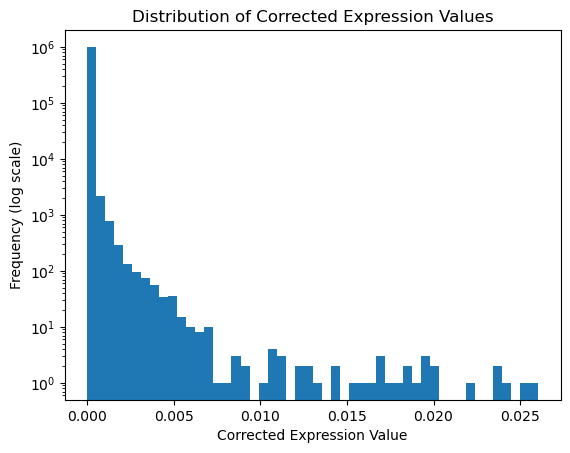

In [20]:
plt.hist(data_matrix.ravel()[:1000000], bins=50, log=True) # Plot first million values
plt.xlabel("Corrected Expression Value")
plt.ylabel("Frequency (log scale)")
plt.title("Distribution of Corrected Expression Values")
plt.show()

### Check multiVI latent dimension based UMAP plots

In [5]:
# sc.pp.neighbors(batch_corrected_rna_adata, use_rep='X_multivi', n_neighbors=15)
# sc.tl.umap(batch_corrected_rna_adata, min_dist=0.5, spread=1.0)

In [2]:
ADATA_PATH = '/home/minhang/mds_project/data/cohort_adata/multiVI_model/adata_multivi_corrected_rna.h5ad'
adata_full = sc.read_h5ad(ADATA_PATH)

In [3]:
adata_full

AnnData object with n_obs × n_vars = 192149 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'CN.label', 'predicted.annotation.score', 'predicted.annotation', 'predicted.pseudotime.score', 'predicted.pseudotime', 'timepoint_type'
    var: 'ID', 'modality', 'chr', 'start', 'end'
    uns: 'CN.label_colors', 'Tech_colors', 'draw_graph', 'neighbors', 'patient_colors', 'predicted.annotation_colors', 'sample_colors', 'timepoint_type_colors', 'umap'
    obsm: 'X_draw_graph_fa', 'X_multivi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [3]:
recipient_adata = adata_full[adata_full.obs['source'] == 'recipient'].copy()
donor_adata = adata_full[adata_full.obs['source'] == 'donor'].copy()

<Axes: title={'center': 'All cells from all patients at all timepoints (batch corrected)'}, xlabel='UMAP1', ylabel='UMAP2'>

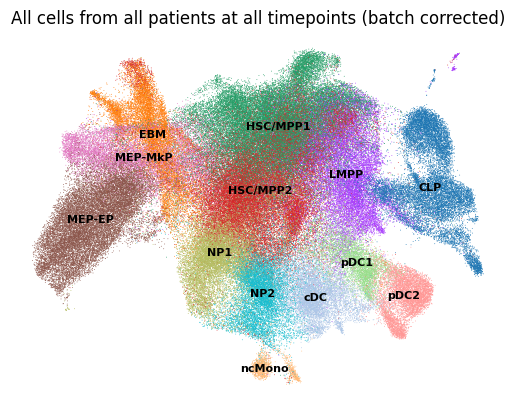

In [10]:
sc.pl.umap(adata_full, color=['predicted.annotation'], frameon=False, title='All cells from all patients at all timepoints (batch corrected)', wspace=0.4, hspace=0.4, legend_loc='on data', legend_fontsize=8, ncols=3, size=1.5, show=False)

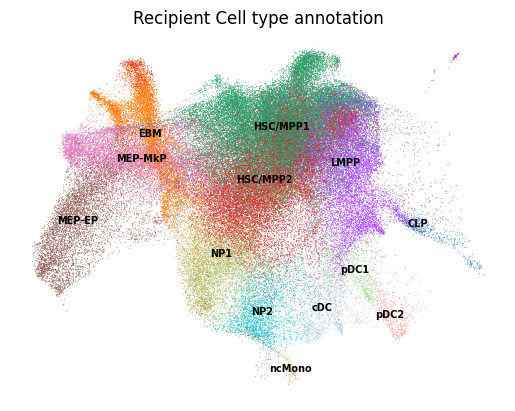

In [16]:
sc.pl.umap(recipient_adata, color=['predicted.annotation'], frameon=False, title='Recipient Cell type annotation', legend_loc='on data', wspace=0.4, hspace=0.4, legend_fontsize=7, size=1.5)

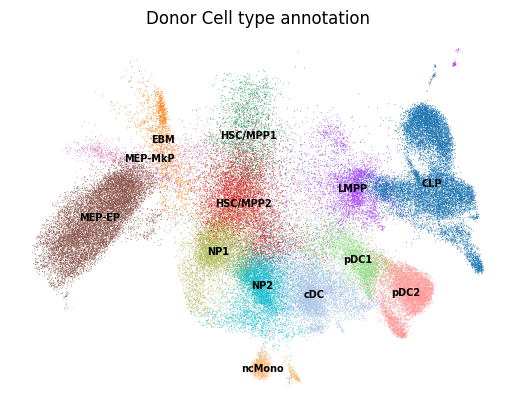

In [17]:
sc.pl.umap(donor_adata, color=['predicted.annotation'], frameon=False, title='Donor Cell type annotation', legend_loc='on data', wspace=0.4, hspace=0.4, legend_fontsize=7, size=1.5)

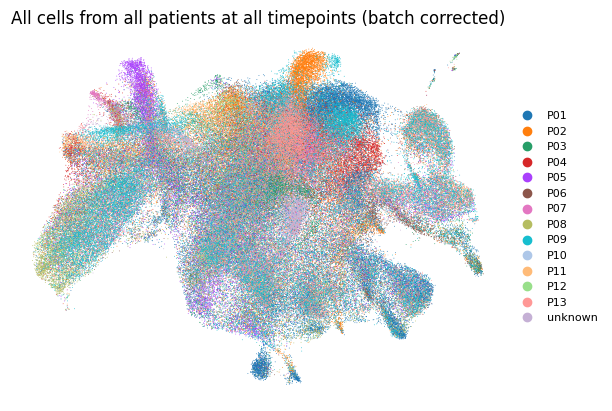

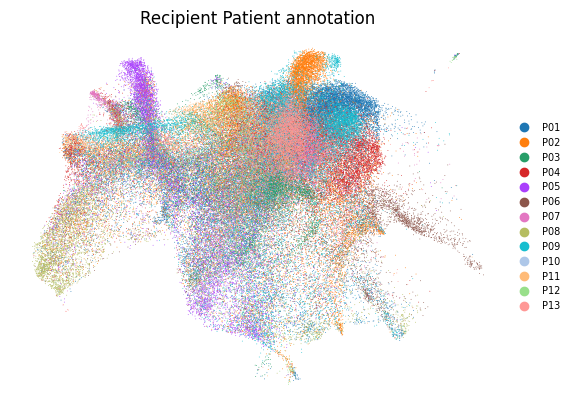

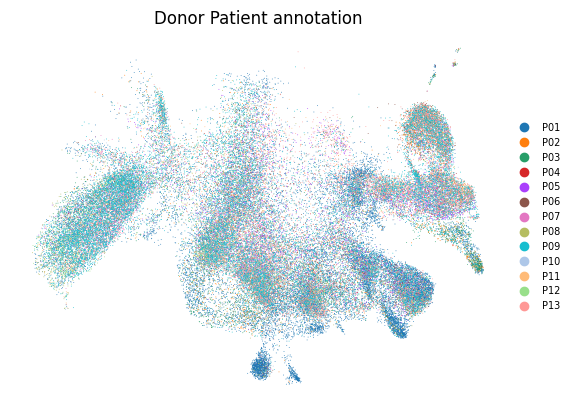

In [19]:
sc.pl.umap(adata_full, color=['patient'], frameon=False, title='All cells from all patients at all timepoints (batch corrected)', wspace=0.4, hspace=0.4, legend_fontsize=8, ncols=3, size=1.5, show=False)
sc.pl.umap(recipient_adata, color=['patient'], frameon=False, title='Recipient Patient annotation', wspace=0.4, hspace=0.4, legend_fontsize=7, size=1.5)
sc.pl.umap(donor_adata, color=['patient'], frameon=False, title='Donor Patient annotation', wspace=0.4, hspace=0.4, legend_fontsize=7, size=1.5)

Number of recipient cells at preSCT timepoint: 64468


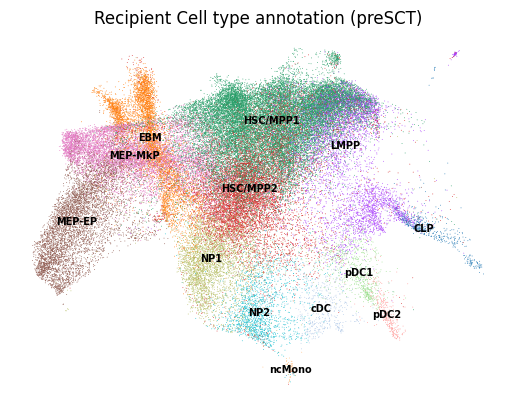

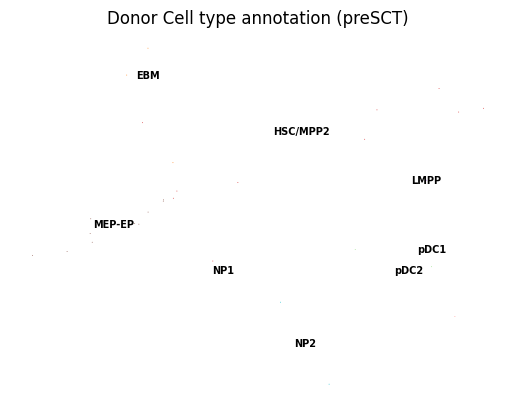

In [27]:
# get timepoint_type = 'preSCT'
recipient_preSCT_adata = recipient_adata[recipient_adata.obs['timepoint_type'] == 'preSCT'].copy()
count_recipient_preSCT = recipient_preSCT_adata.shape[0]
print(f"Number of recipient cells at preSCT timepoint: {count_recipient_preSCT}")
donor_preSCT_adata = donor_adata[donor_adata.obs['timepoint_type'] == 'preSCT'].copy()
sc.pl.umap(recipient_preSCT_adata, color=['predicted.annotation'], frameon=False, title='Recipient Cell type annotation (preSCT)', legend_loc='on data', wspace=0.4, hspace=0.4, legend_fontsize=7, size=1.5)
sc.pl.umap(donor_preSCT_adata, color=['predicted.annotation'], frameon=False, title='Donor Cell type annotation (preSCT)', legend_loc='on data', wspace=0.4, hspace=0.4, legend_fontsize=7, size=1.5)

In [28]:
recipient_adata.obs['timepoint_type'].value_counts(), donor_adata.obs['timepoint_type'].value_counts()

(timepoint_type
 preSCT     64468
 Relapse    46252
 MRD         2077
 Name: count, dtype: int64,
 timepoint_type
 MRD        68114
 Relapse     3303
 preSCT        33
 Name: count, dtype: int64)

In [29]:
recipient_adata.obs['timepoint_type'].value_counts(), donor_adata.obs['timepoint_type'].value_counts()

(timepoint_type
 preSCT     64468
 Relapse    46252
 MRD         2077
 Name: count, dtype: int64,
 timepoint_type
 MRD        68114
 Relapse     3303
 preSCT        33
 Name: count, dtype: int64)

Number of cells in recipient MRD timepoint: 2077


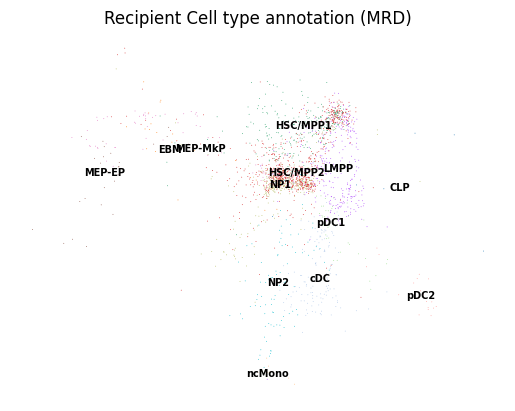

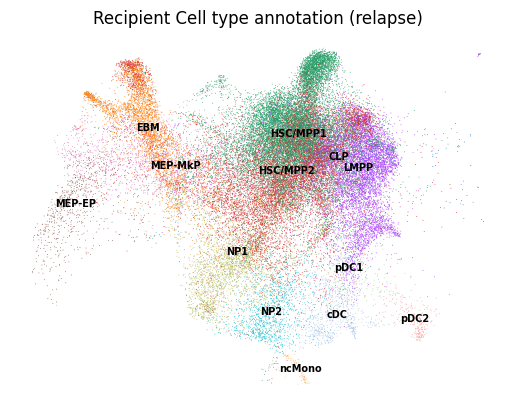

In [30]:
recipient_mrd_adata = recipient_adata[recipient_adata.obs['timepoint_type'] == 'MRD'].copy()
count_recipient_mrd = recipient_mrd_adata.shape[0]
print(f"Number of cells in recipient MRD timepoint: {count_recipient_mrd}")
recipient_relapse_adata = recipient_adata[recipient_adata.obs['timepoint_type'] == 'Relapse'].copy()
count_recipient_relapse = recipient_relapse_adata.shape[0]
sc.pl.umap(recipient_mrd_adata, color=['predicted.annotation'], frameon=False, title='Recipient Cell type annotation (MRD)', legend_loc='on data', wspace=0.4, hspace=0.4, legend_fontsize=7, size=1.5)
sc.pl.umap(recipient_relapse_adata, color=['predicted.annotation'], frameon=False, title='Recipient Cell type annotation (relapse)', legend_loc='on data', wspace=0.4, hspace=0.4, legend_fontsize=7, size=1.5)

In [42]:
mrd_adata = sc.read_h5ad('/home/minhang/mds_project/data/cohort_adata/multiVI_model/adata_mrd_hvg_std_may31.h5ad')

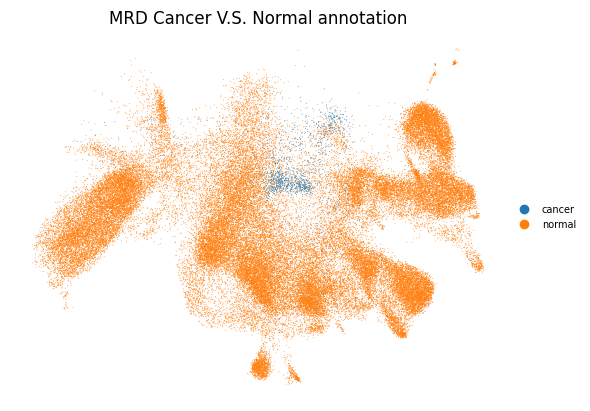

In [43]:
sc.pl.umap(mrd_adata, color=['CN.label'], frameon=False, title='MRD Cancer V.S. Normal annotation', wspace=0.4, hspace=0.4, legend_fontsize=7, size=1.5)

In [41]:
print(count_recipient_preSCT, count_recipient_mrd, count_recipient_relapse)

64468 2077 46252


In [37]:
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # For creating custom legend handles
import numpy as np
import pandas as pd

/tmp/ipykernel_570758/3227077814.py:18: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if not pd.api.types.is_categorical_dtype(recipient_adata.obs['timepoint_type']):


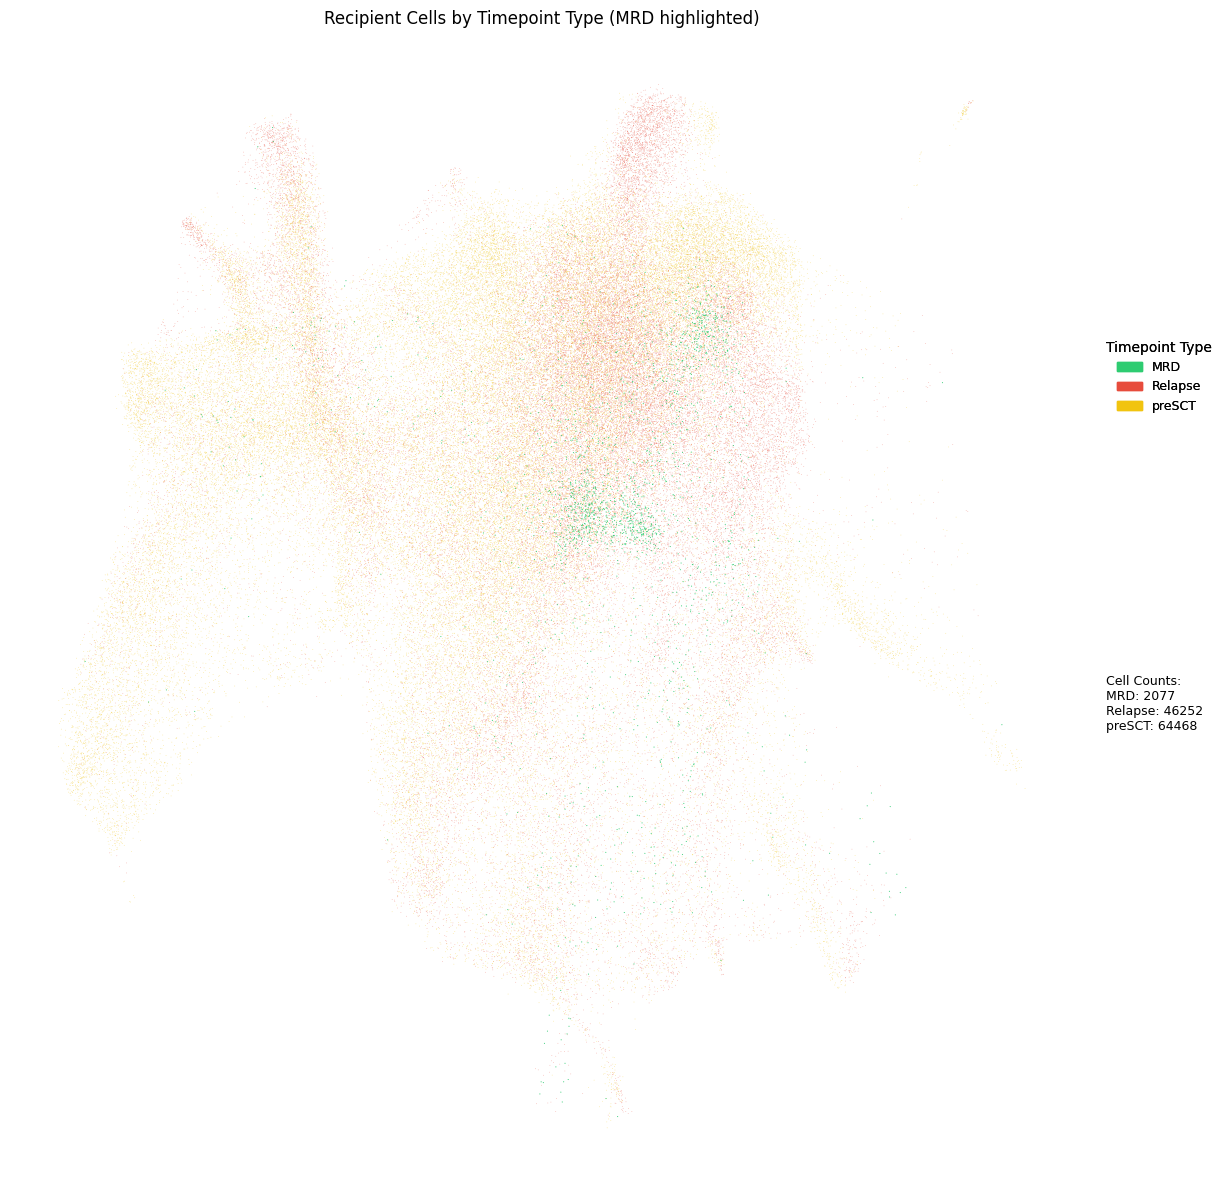

In [40]:
# 1. Define Colors and Aesthetics (as you had, mrd_size changed to 40)
color_map = {
    'MRD': '#2ECC71',      # A nice green
    'preSCT': '#F1C40F',   # A golden yellow
    'Relapse': '#E74C3C',  # A clear red
    # Add other timepoint_type categories if they exist and assign them a relevant color
    # For example, if you have a 'Healthy' category you want to show but dim:
    # 'Healthy': '#BDC3C7' # A light grey
}

default_size = 1
mrd_size = 2.5 # As per your code snippet

alpha_dim = 0.6
alpha_bright = 0.9

# Ensure 'timepoint_type' is categorical and get ordered categories
if not pd.api.types.is_categorical_dtype(recipient_adata.obs['timepoint_type']):
    recipient_adata.obs['timepoint_type'] = recipient_adata.obs['timepoint_type'].astype('category')
# Get categories in their defined order (or current order if not explicitly set)
# This helps ensure legends are consistent.
ordered_categories = recipient_adata.obs['timepoint_type'].cat.categories.tolist()


# 2. Create the figure and axis
fig, ax = plt.subplots(figsize=(15, 12)) # Adjust figsize as needed

# 3. Subset data
adata_non_mrd = recipient_adata[recipient_adata.obs['timepoint_type'] != 'MRD'].copy()
adata_mrd = recipient_adata[recipient_adata.obs['timepoint_type'] == 'MRD'].copy()

# 4. Plot non-MRD cells first (dimmed)
if adata_non_mrd.n_obs > 0:
    sc.pl.umap(adata_non_mrd,
               color='timepoint_type', # Pass the column name directly
               palette=color_map,      # Pass the full color_map, scanpy will pick relevant ones
               ax=ax,
               frameon=False,
               show=False,
               legend_loc=None,        # Suppress legend for this layer
               size=default_size,
               alpha=alpha_dim)

# 5. Plot MRD cells on top (brighter and larger)
if adata_mrd.n_obs > 0:
    sc.pl.umap(adata_mrd,
               color='timepoint_type', # Pass the column name
               palette=color_map,      # Pass the full color_map
               ax=ax,
               frameon=False,
               show=False,
               legend_loc=None,        # Suppress legend for this layer
               size=mrd_size,
               alpha=alpha_bright)

# 6. Set plot title
ax.set_title(f'Recipient Cells by Timepoint Type (MRD highlighted)')

# 7. Create and add custom legend for timepoint_type colors
type_handles = []
type_labels = []

for category in ordered_categories:
    if category in color_map: # Only create legend items for categories in your map
        size_for_legend = mrd_size / 200 * 10 if category == 'MRD' else default_size / 200 * 10 # Scale marker size for legend
        patch = mpatches.Patch(color=color_map[category], label=category) # Simpler patch
        # Or for circle markers:
        # patch = plt.Line2D([0], [0], marker='o', color='w', # 'w' for invisible line
        #                    label=category,
        #                    markerfacecolor=color_map[category],
        #                    markersize=8 if category == 'MRD' else 6, # Adjust legend marker size
        #                    linestyle='None')
        type_handles.append(patch)
        type_labels.append(category)

if type_handles:
    legend1 = ax.legend(type_handles, type_labels,
                        loc='center left',
                        bbox_to_anchor=(1.02, 0.7), # Position to the right side, adjust Y as needed
                        frameon=False,
                        title='Timepoint Type',
                        fontsize=9)
    ax.add_artist(legend1) # Needed if you plan to add another legend object

# 8. Create and add custom text block for cell counts
counts = recipient_adata.obs['timepoint_type'].value_counts()
count_info_lines = ["Cell Counts:"]

for category in ordered_categories: # Iterate in the same order for consistency
    count = counts.get(category, 0) # Get count, default to 0 if category not in this specific dataset
    count_info_lines.append(f"{category}: {count}")

count_text = "\n".join(count_info_lines)

from matplotlib.offsetbox import AnchoredText
# Adjust bbox_to_anchor to position it neatly relative to the first legend or plot border
at = AnchoredText(count_text,
                  loc='upper left', # Anchoring point of the text box
                  bbox_to_anchor=(1.02, 0.45), # Position relative to axes (x, y)
                                              # (1.02 means just outside right edge)
                                              # Y value (0.45) positions it below the first legend
                  frameon=False,
                  bbox_transform=ax.transAxes, # Use axes coordinates for bbox_to_anchor
                  prop=dict(size=9))
ax.add_artist(at)

# 9. Adjust layout to make space for legends and show plot
# The `rect` parameter in tight_layout helps reserve space: [left, bottom, right, top]
plt.tight_layout(rect=[0, 0, 0.82, 1]) # Adjust the `right` value (0.82) as needed

plt.show()

In [33]:
adata_non_mrd

AnnData object with n_obs × n_vars = 110720 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'CN.label', 'predicted.annotation.score', 'predicted.annotation', 'predicted.pseudotime.score', 'predicted.pseudotime', 'timepoint_type'
    var: 'ID', 'modality', 'chr', 'start', 'end'
    uns: 'CN.label_colors', 'Tech_colors', 'draw_graph', 'neighbors', 'patient_colors', 'predicted.annotation_colors', 'sample_colors', 'timepoint_type_colors', 'umap'
    obsm: 'X_draw_graph_fa', 'X_multivi', 'X_umap'
    obsp: 'connectivities', 'distances'

Old

In [4]:
import scvelo as scv
import scipy.sparse

In [ ]:
adata_full

AnnData object with n_obs × n_vars = 192149 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'CN.label', 'predicted.annotation.score', 'predicted.annotation', 'predicted.pseudotime.score', 'predicted.pseudotime', 'timepoint_type'
    var: 'ID', 'modality', 'chr', 'start', 'end'
    uns: 'CN.label_colors', 'Tech_colors', 'draw_graph', 'neighbors', 'patient_colors', 'predicted.annotation_colors', 'sample_colors', 'timepoint_type_colors', 'umap'
    obsm: 'X_draw_graph_fa', 'X_multivi', 'X_umap'
    obsp: 'connectivities', 'distances'

In [5]:
adata_full.obs['predicted.pseudotime'] = pd.to_numeric(adata_full.obs['predicted.pseudotime'], errors='coerce')

In [6]:
adata_full.obsm['X_multivi'].shape

(192149, 23)

In [ ]:
scv.pp.moments(adata_full, use_rep='X_multivi', n_pcs=23, n_neighbors=30)

computing neighbors
    finished (0:01:25) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)


: 

In [ ]:
print("Creating dummy spliced and unspliced layers...")
if 'spliced' not in adata_full.layers:
    adata_full.layers['spliced'] = adata_full.X.copy()  # Use total counts as "spliced"
if 'unspliced' not in adata_full.layers:
    # Create a zero matrix for "unspliced"
    adata_full.layers['unspliced'] = scipy.sparse.csr_matrix(adata_full.X.shape, dtype=adata_full.X.dtype)

# --- Now, try to compute velocities using a basic model ---
# This will use the dummy layers. The "velocities" will be based on total expression.
print("Running scv.tl.velocity (with dummy layers)...")
try:
    # mode='deterministic' is a simpler model.
    # fit_offset=False might be more stable with dummy data.
    scv.tl.velocity(adata_full, mode='deterministic', fit_offset=False, use_raw=False) # use_raw=False to use layers['spliced'], ['unspliced']
    print("scv.tl.velocity completed.")
except Exception as e:
    print(f"Error during scv.tl.velocity: {e}")
    # If deterministic fails, you might try 'stochastic', but it's less likely to give meaningful
    # direction without true splicing kinetics. The main goal here is to populate adata.layers['velocity'].

# Check if 'velocity' was added to layers
if 'velocity' in adata_full.layers:
    print("'velocity' layer successfully created.")

    # --- Proceed with velocity_graph and plotting ---
    print("Running scv.tl.velocity_graph...")
    try:
        scv.tl.velocity_graph(adata_full, n_jobs=8) # This should now find adata.layers['velocity']
        print("scv.tl.velocity_graph completed.")

        # Optional: Identify root cell for latent time to help orient the plot
        if 'predicted.pseudotime' in adata_full.obs.columns:
            adata_full.obs['predicted.pseudotime'] = pd.to_numeric(adata_full.obs['predicted.pseudotime'], errors='coerce')
            if not adata_full.obs['predicted.pseudotime'].isnull().all():
                root_cell_index = adata_full.obs['predicted.pseudotime'].idxmin()
                if root_cell_index in adata_full.obs_names:
                    adata_full.uns['iroot'] = adata_full.obs.index.get_loc(root_cell_index)
                    scv.tl.latent_time(adata_full, root_key='iroot')
                    print("Latent time computed.")
                else:
                    print(f"Warning: Root cell index '{root_cell_index}' not found in adata.obs_names. Skipping latent_time.")
            else:
                print("Warning: 'predicted.pseudotime' contains all NaNs. Skipping latent_time.")

        # Visualize the stream plot
        print("Plotting velocity_embedding_stream...")
        scv.pl.velocity_embedding_stream(adata_full,
                                         basis='umap',
                                         color='predicted.pseudotime',
                                         cmap='viridis',
                                         legend_fontsize=8,
                                         title='Pseudotime-Guided Trajectories (via scVelo streams)',
                                         save='pseudotime_stream_umap_workaround.png',
                                         show=True,
                                         density=1.0,
                                         smooth=0.5)
        print("Plotting complete.")
    except Exception as e:
        print(f"Error during velocity_graph or plotting: {e}")
else:
    print("Failed to create 'velocity' layer. Cannot proceed with velocity_graph and plotting.")

Creating dummy spliced and unspliced layers...
Running scv.tl.velocity (with dummy layers)...
Normalized count data: unspliced.
computing moments based on connectivities


Annotate the multiVI batch corrected adata with: 
1. Cell type 
2. Healthy V.S. malignant 
3. Time point type

Ran and saved (no need to run again)

In [26]:
def annotate_malignant_normal(adata, annotation_file):
    """
    Annotate cells with malignant vs. normal labels using a CSV file.
    Donor cells are set to 'normal' if no CN.label is provided.
    """
    malignant_annotation = pd.read_csv(annotation_file)
    malignant_annotation['barcode'] = malignant_annotation['Unnamed: 0'].str.strip()
    malignant_annotation.set_index('barcode', inplace=True)
    
    merged_data = pd.merge(
        adata.obs,
        malignant_annotation[['CN.label']],
        left_index=True,
        right_index=True,
        how='left'
    )
    # For donor cells with missing CN.label, set label to 'normal'
    merged_data.loc[(merged_data['source'] == 'donor') & (merged_data['CN.label'].isna()), 'CN.label'] = 'normal'
    adata.obs = merged_data
    return adata

In [31]:
def integrate_cell_type_annotations(adata, cell_type_file):
    """
    Integrate cell type annotations from a CSV file into the AnnData object.
    
    Parameters:
    - adata: AnnData object with cell barcodes as index in adata.obs
    - cell_type_file: Path to the CSV file with cell type annotations
    
    Returns:
    - Updated AnnData object with cell type annotations in adata.obs
    """
    print("Integrating cell type annotations...")
    
    # Read the cell type annotation file
    celltype_df = pd.read_csv(cell_type_file)
    
    # Ensure barcode column is properly formatted
    if 'Unnamed: 0' in celltype_df.columns:
        celltype_df.rename(columns={'Unnamed: 0': 'barcode'}, inplace=True)
    
    # Set barcode as index for merging
    celltype_df.set_index('barcode', inplace=True)
    
    # Select only the columns we want to integrate
    annotation_cols = [
        'predicted.annotation.score', 
        'predicted.annotation', 
        'predicted.pseudotime.score', 
        'predicted.pseudotime'
    ]
    
    # Verify that all columns exist in the DataFrame
    available_cols = [col for col in annotation_cols if col in celltype_df.columns]
    missing_cols = [col for col in annotation_cols if col not in celltype_df.columns]
    
    if missing_cols:
        print(f"Warning: The following requested columns were not found in the cell type file: {missing_cols}")
    
    # Extract only the available columns we want to merge
    celltype_df_subset = celltype_df[available_cols].copy()
    
    # Report on size of datasets
    print(f"AnnData observations: {adata.n_obs}")
    print(f"Cell type annotations: {len(celltype_df_subset)}")
    
    # Check for overlapping barcodes
    common_barcodes = set(adata.obs.index) & set(celltype_df_subset.index)
    print(f"Common barcodes: {len(common_barcodes)} of {adata.n_obs} cells")
    
    # Merge annotations with the existing adata.obs
    merged_obs = pd.merge(
        adata.obs,
        celltype_df_subset,
        left_index=True,
        right_index=True,
        how='left'  # Keep all cells in adata, add annotations where available
    )
    
    # Update adata.obs with the merged data
    adata.obs = merged_obs
    
    # Report on annotation completeness
    for col in available_cols:
        missing_count = adata.obs[col].isna().sum()
        missing_percent = (missing_count / adata.n_obs) * 100
        print(f"Column '{col}': {missing_count} missing values ({missing_percent:.1f}%)")
    
    return adata

In [27]:
batch_corrected_rna_adata = annotate_malignant_normal(batch_corrected_rna_adata, '/home/minhang/mds_project/data/cohort_adata/13_all.CN.label.recipient.csv')

/tmp/ipykernel_435333/3057093423.py:6: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  malignant_annotation = pd.read_csv(annotation_file)


In [32]:
celltypes_csv_path = '/home/minhang/mds_project/data/cohort_adata/CD34pos.annotation.csv'

batch_corrected_rna_adata = integrate_cell_type_annotations(batch_corrected_rna_adata, celltypes_csv_path)

Integrating cell type annotations...
AnnData observations: 192149
Cell type annotations: 192149
Common barcodes: 192149 of 192149 cells
Column 'predicted.annotation.score': 0 missing values (0.0%)
Column 'predicted.annotation': 0 missing values (0.0%)
Column 'predicted.pseudotime.score': 0 missing values (0.0%)
Column 'predicted.pseudotime': 0 missing values (0.0%)


In [29]:
batch_corrected_rna_adata

AnnData object with n_obs × n_vars = 192149 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'library', 'exp.ID', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_dsb', 'nFeature_dsb', 'nCount_ADT', 'nFeature_ADT', 'hash.ID', 'scDblFinder.score', 'scDblFinder.weighted', 'scDblFinder.cxds_score', 'Lane', 'patient', 'marker', 'Time', 'batch', 'Tech', 'sample', 'source', 'soup.singlet_posterior', '_indices', '_scvi_batch', '_scvi_labels', 'CN.label'
    var: 'ID', 'modality', 'chr', 'start', 'end'
    uns: 'neighbors', 'umap', 'Tech_colors', 'sample_colors', 'patient_colors'
    obsm: 'X_multivi', 'X_umap'
    obsp: 'distances', 'connectivities'

In [36]:
def extract_timepoint_type(sample_name):
    """
    Extract timepoint type from sample name.
    """
    if 'preSCT' in sample_name:
        return 'preSCT'
    elif 'MRD' in sample_name:
        return 'MRD'
    elif 'Relapse' in sample_name:
        return 'Relapse'
    else:
        return 'Unknown'
    
batch_corrected_rna_adata.obs['timepoint_type'] = batch_corrected_rna_adata.obs['sample'].apply(extract_timepoint_type)

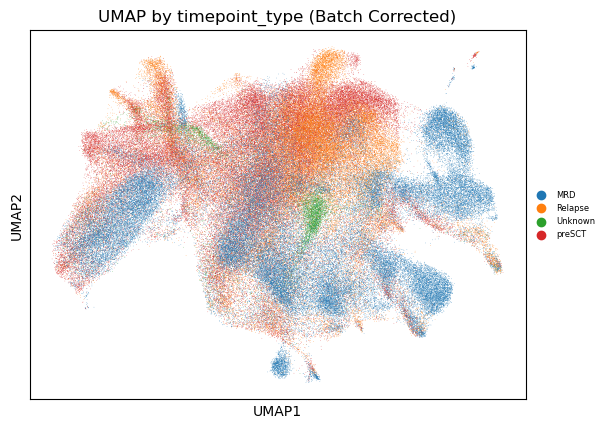

In [ ]:
sc.pl.umap(batch_corrected_rna_adata, color=['CN.label'], title='UMAP by CN label (Batch Corrected)', show=True, legend_loc='on data', legend_fontsize=6)
sc.pl.umap(batch_corrected_rna_adata, color=['predicted.annotation'], title='UMAP by cell type (Batch Corrected)', show=True, legend_loc='on data', legend_fontsize=6)
sc.pl.umap(batch_corrected_rna_adata, color=['timepoint_type'], title='UMAP by timepoint_type (Batch Corrected)', show=True, legend_fontsize=6)

In [38]:
print(batch_corrected_rna_adata.obs['sample'].value_counts())
print(batch_corrected_rna_adata.obs['timepoint_type'].value_counts())
print(batch_corrected_rna_adata.obs['sample'].unique())

sample
P01_MRD_2          18587
P01_preSCT         14830
P04_Relapse         7810
P02_Relapse_4       7070
P01_preSCT_2        6877
unknown_unknown     6362
P03_Relapse         5895
P13_MRD             5781
P02_preSCT_1        5762
P09_MRD_2           5508
P05_Relapse         5307
P09_MRD_4           4762
P09_MRD             4686
P07_Relapse         4486
P09_Relapse         4470
P05_MRD             4368
P11_preSCT          4043
P11_MRD             4037
P09_preSCT_2        4015
P09_preSCT_1        3918
P10_preSCT          3786
P01_Relapse         3752
P02_Relapse_3       3559
P06_MRD             3276
P08_preSCT_1        3187
P13_Relapse_2       3109
P02_preSCT_2        2951
P05_preSCT          2905
P06_preSCT_1        2820
P10_MRD             2718
P09_MRD_3           2575
P06_preSCT_2        2505
P12_MRD             2504
P03_MRD_2           2361
P07_MRD             2191
P08_preSCT_2        1980
P03_MRD_1           1731
P08_Relapse         1585
P02_MRD_2           1479
P08_MRD           

In [40]:
batch_corrected_rna_adata.write_h5ad(output_adata_corrected_rna_path, compression="gzip")